# Hydrogen Dispatch Example

This example demonstrates how to use the dispatch controller capability in H2Integrate. In the H2Integrate input file (`./inputs/h2i_wind_to_h2_storage.yaml`), the `control_method` and the `control_parameters` are set as follows:

```yaml
technologies:
    h2_storage:
        control_strategy:
            method: "demand_open_loop_controller"
        control_parameters:
            resource_rate_units: "kg/h"
            max_capacity: 60000.0  # kg
            max_charge_percent: 1.0  # percent as decimal
            min_charge_percent: 0.1  # percent as decimal
            init_charge_percent: 0.25  # percent as decimal
            max_charge_rate: 10000.0  # kg/time step
            max_discharge_rate: 10000.0  # kg/time step
            charge_efficiency: 1.0 # percent as decimal
            discharge_efficiency: 1.0 # percent as decimal
            demand_profile: 5000  # Example: 10 time steps with 5000 kg/time step demand. Scalar indicates constant demand, array-like indicates dynamic demand
```

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
from h2integrate.core.h2integrate_model import H2IntegrateModel

c:\Users\jjasa\Documents\git\H2Integrate\examples\14_wind_hydrogen_dispatch\log\hybrid_systems_2025-08-07T12.39.40.296349.log


In [2]:
# Create an H2Integrate model
model = H2IntegrateModel(Path("./inputs/h2i_wind_to_h2_storage.yaml"))

# Run the model
model.run()
model.post_process()

Turbine hub height (130) does not equal site_info.hub_height (97.0)
updating wind resource hub-height to 130.0m and redownloading wind resource data


34 Input(s) in 'model'

varname                               val                   units      prom_name                                                
------------------------------------  --------------------  ---------  ---------------------------------------------------------
plant
  wind_to_electrolyzer_cable
    electricity_in                    |40393548.91233188|   kW         wind_to_electrolyzer_cable.electricity_in                
  electrolyzer
    eco_pem_electrolyzer_performance
      electricity_in                  |40393548.91233188|   kW         electrolyzer.electricity_in                              
      electrolyzer_size_mw            [720.]                MW         electrolyzer.electrolyzer_size_mw                        
    singlitico_electrolyzer_cost
      total_hydrogen_produced         [58145418.36646514]   kg/year    electrolyzer.total_hydrogen_produced                     
      electricity_in                  |40393548.91233188|   kW         electrolyze

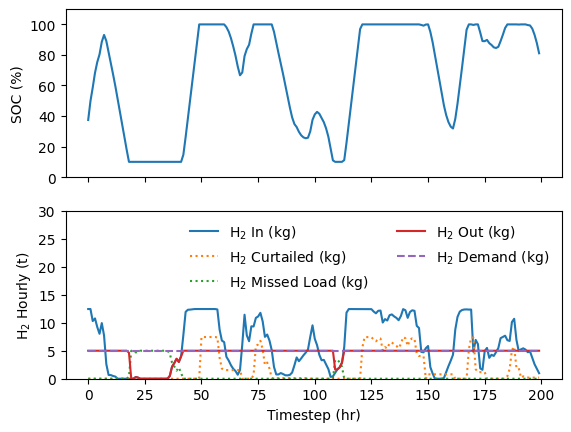

In [3]:
fig, ax = plt.subplots(2, 1, sharex=True)

start_hour = 0
end_hour = 200
total_time_steps = model.prob.get_val("h2_storage.hydrogen_soc").size
demand_profile = [
    model.technology_config["technologies"]["h2_storage"]["model_inputs"]["control_parameters"][
        "demand_profile"
    ]
    * 1e-3
] * total_time_steps

ax[0].plot(
    range(start_hour, end_hour),
    model.prob.get_val("h2_storage.hydrogen_soc", units="percent")[start_hour:end_hour],
    label="SOC",
)
ax[0].set_ylabel("SOC (%)")
ax[0].set_ylim([0, 110])

ax[1].plot(
    range(start_hour, end_hour),
    model.prob.get_val("h2_storage.hydrogen_in", units="t/h")[start_hour:end_hour],
    linestyle="-",
    label="H$_2$ In (kg)",
)
ax[1].plot(
    range(start_hour, end_hour),
    model.prob.get_val("h2_storage.hydrogen_curtailed", units="t/h")[start_hour:end_hour],
    linestyle=":",
    label="H$_2$ Curtailed (kg)",
)
ax[1].plot(
    range(start_hour, end_hour),
    model.prob.get_val("h2_storage.hydrogen_missed_load", units="t/h")[start_hour:end_hour],
    linestyle=":",
    label="H$_2$ Missed Load (kg)",
)
ax[1].plot(
    range(start_hour, end_hour),
    model.prob.get_val("h2_storage.hydrogen_out", units="t/h")[start_hour:end_hour],
    linestyle="-",
    label="H$_2$ Out (kg)",
)
ax[1].plot(
    range(start_hour, end_hour),
    demand_profile[start_hour:end_hour],
    linestyle="--",
    label="H$_2$ Demand (kg)",
)
ax[1].set_ylim([0, 30])
ax[1].set_ylabel("H$_2$ Hourly (t)")
ax[1].set_xlabel("Timestep (hr)")

plt.legend(ncol=2, frameon=False)